In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hypertools as hyp
import quail
from scipy.stats import pearsonr as corr
from scipy.signal import resample

%matplotlib inline
sns.set_context('poster')
sns.set_style('ticks')
plt.rc('figure', figsize=(12, 8))

In [2]:
rawdir = '../../data/raw/'
datadir = '../../data/processed/'

In [3]:
# load in raw annotation file
movie_annotations = pd.read_excel(rawdir+'Sherlock_Segments_1000_NN_2017.xlsx')
movie_annotations['Scene Segments'].fillna(method='ffill', inplace=True)

In [4]:
# load in full features model
full_features_model = np.load(datadir+'models_t100_v50_r10.npy')[0]

In [5]:
# model parameters
ntopics = 100
m_wsize = 50

# vectorizer parameters
vectorizer = {
    'model' : 'CountVectorizer', 
    'params' : {
        'stop_words' : 'english'
    }
}

# topic model parameters
semantic = {
    'model' : 'LatentDirichletAllocation', 
    'params' : {
        'n_components' : ntopics,
        'learning_method' : 'batch',
        'random_state' : 0
    }
}

## define some functions

In [6]:
# fit a topic model to the selected feature
def model_feature(feat_ser, w_size, vec_params, sem_params, corpus):

    # create list of text samples from annotations
    movie_text = feat_ser.fillna('').tolist()
    
    # create sliding window of text samples
    movie_windows = []
    for idx, sentence in enumerate(movie_text):
        movie_windows.append(','.join(movie_text[idx:idx+w_size]))

    # vectorizer and topic model parameters
    vectorizer = vec_params
    semantic = sem_params

    # use hypertools to create movie model
    movie_model = hyp.tools.format_data(movie_windows, vectorizer=vec_params, semantic=sem_params, corpus=corpus)[0]

    # scene description are by shot, not TR, so stretch the model to be in TRs
    ranges =[[d['Start Time (TRs, 1.5s)'],d['End Time (TRs, 1.5s)']] for i, d in movie_annotations.iterrows()] 
    expanded = []
    for i in range(1976):
        try:
            idx = np.where([i>=r[0] and i<=r[1] for r in ranges])[0][0]
            expanded.append(movie_model[idx, :])
        except:
            expanded.append(movie_model[0, :])
    
    return np.array(expanded)

In [7]:
# isolate a single feature
def isolate_feature(df, feature):
    return df[feature]

## isolate features used in full model

In [8]:
features_df = movie_annotations.loc[:,'Scene Details - A Level ':'Words on Screen ']
features_df.columns = ['Narrative details', 'Indoor vs outdoor', 'Characters on screen', 'Character in focus', 'Character speaking', 'Location', 'Camera angle', 'Music presence', 'Text on screen']

# create corpus for training model

In [9]:
# create overlapping text windows based on presence of all features
full_text = features_df.apply(lambda x: ','.join(x.fillna('')), axis=1).values.tolist()
full_windows = []

for idx, sentence in enumerate(full_text):
    full_windows.append(','.join(full_text[idx:idx+m_wsize]))

## model each individual feature

In [10]:
feature_model_structures = {}

# iteratively isolate one feature from the descriptions
for feat in features_df.columns:
    print('\nisolating '+str(feat))
    single_feat = isolate_feature(features_df,feat)
    
    # transform feature with model trained on full features
    print('computing feature model')
    single_feature_model = model_feature(single_feat, m_wsize, vectorizer, semantic, full_windows)
    
    # represent feature model's temporal structure as timepoints x timepoints correlation matrix
    feature_structure = pd.DataFrame(single_feature_model).T.corr().values.ravel()
    
    feature_model_structures[feat] = feature_structure
    
# add the full features model structure
feature_model_structures['Full model'] = pd.DataFrame(full_features_model).T.corr().values.ravel()


isolating Narrative Details
computing feature model

isolating Indoor vs Outdoor
computing feature model

isolating Characters on Screen
computing feature model

isolating Character in Focus
computing feature model

isolating Character Speaking
computing feature model

isolating Location
computing feature model

isolating Camera Angle
computing feature model

isolating Music Presence
computing feature model


KeyboardInterrupt: 

In [23]:
feat_corrs = pd.DataFrame(feature_model_structures).corr()

In [27]:
feat_corrs

,Narrative Details,Indoor vs Outdoor,Characters on Screen,Character in Focus,Character Speaking,Location,Camera Angle,Music Presence,Text on Screen,All features
Narrative Details,1.000000,0.229183,0.629242,0.544634,0.575887,0.610037,0.368575,0.051386,0.378137,0.992932
Indoor vs Outdoor,0.229183,1.000000,0.172463,0.203193,0.159701,0.360774,0.158268,-0.067608,0.088120,0.231053
Characters on Screen,0.629242,0.172463,1.000000,0.891718,0.853584,0.561742,0.205118,-0.138045,0.321081,0.641117
Character in Focus,0.544634,0.203193,0.891718,1.000000,0.802947,0.578446,0.119447,-0.159988,0.341107,0.554531
Character Speaking,0.575887,0.159701,0.853584,0.802947,1.000000,0.557568,0.187176,-0.105510,0.282047,0.584280
Location,0.610037,0.360774,0.561742,0.578446,0.557568,1.000000,0.186663,-0.104315,0.263643,0.618270
Camera Angle,0.368575,0.158268,0.205118,0.119447,0.187176,0.186663,1.000000,-0.023033,0.155405,0.364747
Music Presence,0.051386,-0.067608,-0.138045,-0.159988,-0.105510,-0.104315,-0.023033,1.000000,0.084764,0.047107
Text on Screen,0.378137,0.088120,0.321081,0.341107,0.282047,0.263643,0.155405,0.084764,1.000000,0.381043
All features,0.992932,0.231053,0.641117,0.554531,0.584280,0.618270,0.364747,0.047107,0.381043,1.000000


In [59]:
cmap = sns.diverging_palette(10, 240, as_cmap=True)

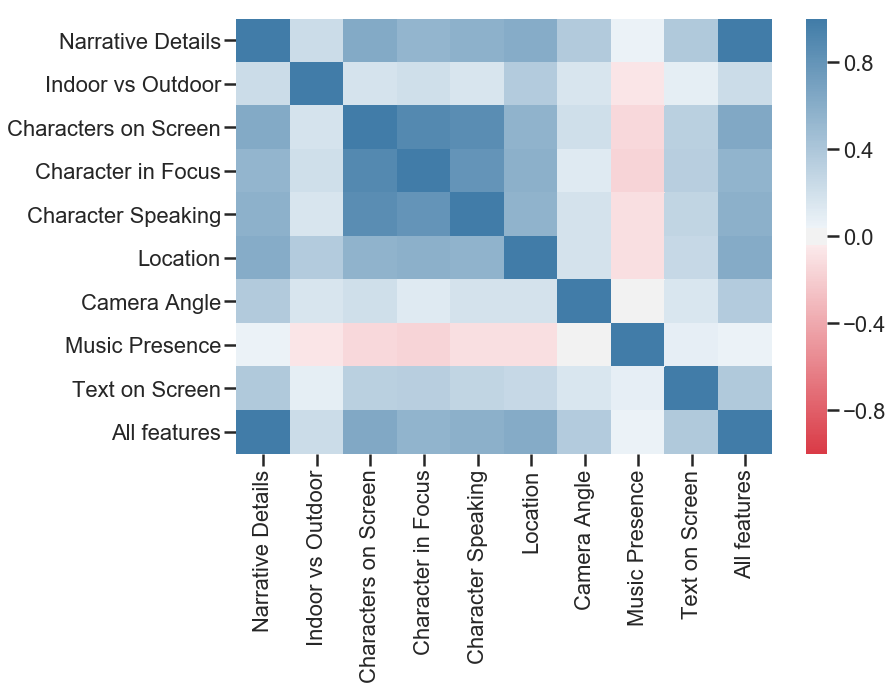

In [60]:
corrmat = sns.heatmap(feat_corrs, vmin=-1, vmax=1, cmap=cmap)

In [61]:
corrmat.figure.savefig('../../paper/figs/old/5.3_feature_model_corrmat.pdf', bbox_inches='tight')